In [2]:
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
import extract_spectral
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
importlib.reload(extract_spectral)
import radiometric_calib_utils as rcu
import mutils
import extract_spectral as espect
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import ceil

- sunglint correction has to be conducted pixel-wise method
- because glint patterns appear to be randomised spatially, and autocorrelations may be weak, except for under the circumstances of gravity waves
- an algorithm which can account for randomly distributed glint patterns is more robust than one that is dependent on autocorrelations because waves are quite dynamic
- waves have different wavelengths, wave slopes have different tilt and azimuth
- the autocorrelation patterns may also not be consistent across space if there are different wind directions --> variable wave attributes which results in variable sun glint distributions

### Does glitter spectra for turbid and non-turbid waters differ?
- if glitter spectra for turbid and non-turbid waters differ, we can have texture/context-aware corrections
- otherwise, rely on neighbourhood information

# Plot bboxes

In [3]:
wavelengths = mutils.sort_bands_by_wavelength()
wavelengths_idx = np.array([i[0] for i in wavelengths])
wavelengths = {i[0]:i[1] for i in wavelengths}
wavelengths

{5: 444,
 0: 475,
 6: 531,
 1: 560,
 7: 650,
 2: 668,
 8: 705,
 4: 717,
 9: 740,
 3: 842}

In [23]:
ES = espect.ExtractSpectral(r"saved_bboxes")
img_bboxes = ES.store_bboxes()
img_bboxes


{'C:/Users/PAKHUIYING/Documents/sunglint_correction/rawimages/rawimages': {'IMG_0404_1.tif': {'turbid': [[507,
     568],
    [664, 751]],
   'water': [[967, 769], [1024, 826]]}}}

In [22]:
parent_dir = list(img_bboxes)[0]
img_fp = 'IMG_0403_1.tif'
fp = os.path.join(parent_dir,img_fp)
cap = mutils.import_captures(fp)
im_aligned = mutils.align_captures(cap,img_type = "reflectance")

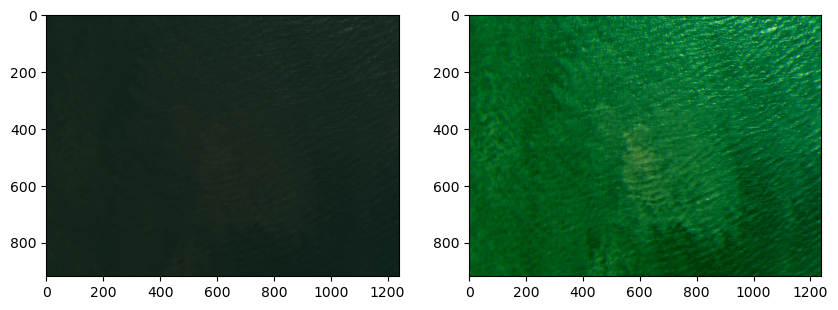

In [21]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
rgb_band_indices = [2,1,0]
rgb_im = np.take(im_aligned,rgb_band_indices,axis=2)
# rgb_im_normalised = []
im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

rgb_im_normalised = np.zeros((im_aligned.shape[0],im_aligned.shape[1],len(rgb_band_indices)), dtype=np.float32)
for i,rgb_i in enumerate(rgb_band_indices):
    rgb_im_normalised[:,:,i] = imageutils.normalize(im_aligned[:,:,rgb_i], im_min, im_max)

axes[0].imshow(rgb_im)
axes[1].imshow(rgb_im_normalised)
plt.show()



## Plot bboxes for all saved images

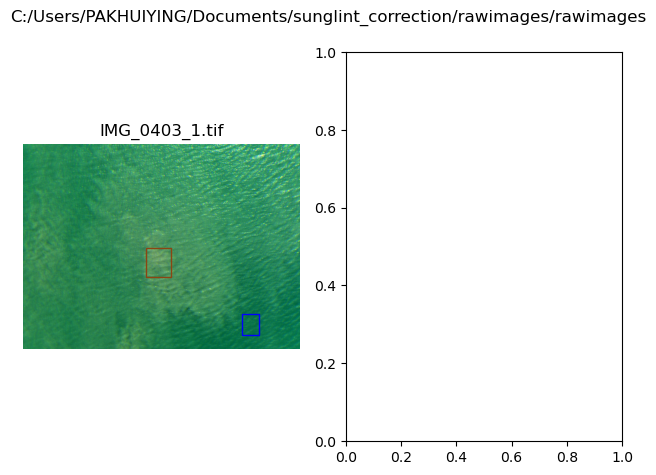

In [5]:
ES = espect.ExtractSpectral(r"saved_bboxes")
ES.plot_bboxes(show_n = None,figsize=(10,20))

In [6]:
warp_mode = cv2.MOTION_HOMOGRAPHY
img_type = "reflectance"
parent_dir = list(img_bboxes)[0]
img_fp = 'IMG_0403_1.tif'
fp = os.path.join(parent_dir,img_fp)
print(fp)
cap = mutils.import_captures(fp)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,_ = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
bboxes = img_bboxes[parent_dir][img_fp]
# for category, bbox in bboxes:
bboxes_i = bboxes['water']
bboxes

C:/Users/PAKHUIYING/Documents/sunglint_correction/rawimages/rawimages\IMG_0403_1.tif


{'turbid': [[550, 468], [662, 594]], 'water': [[983, 764], [1058, 858]]}

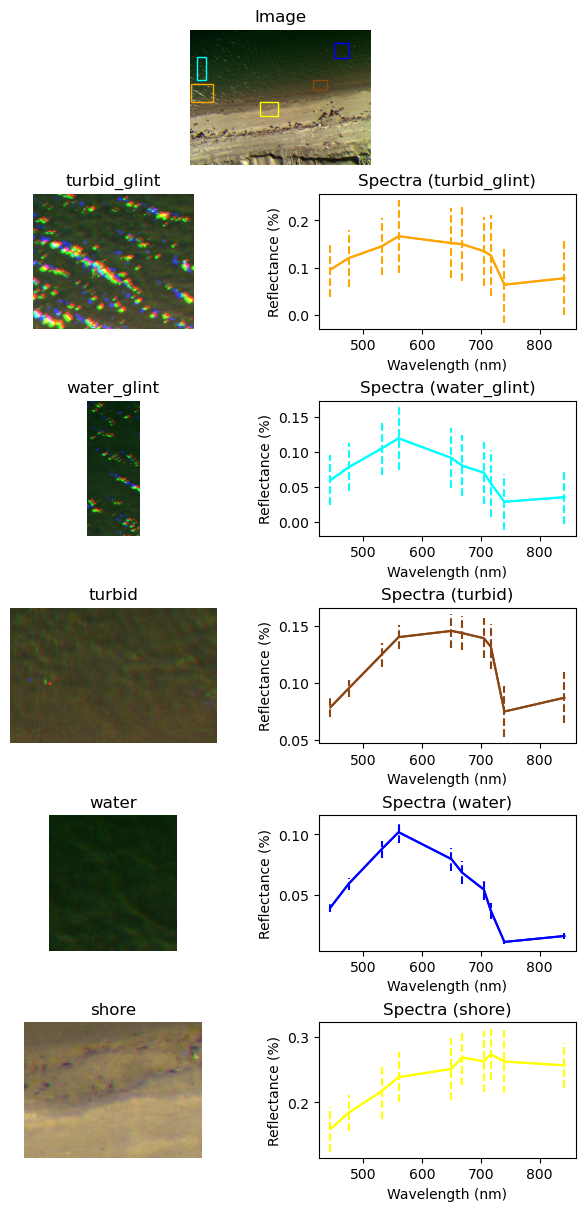

In [142]:
ES = espect.ExtractSpectral(r"saved_bboxes")
ES.plot_multispectral(parent_dir,img_fp,img_bboxes=img_bboxes,warp_matrices=warp_matrices, cropped_dimensions=cropped_dimensions)

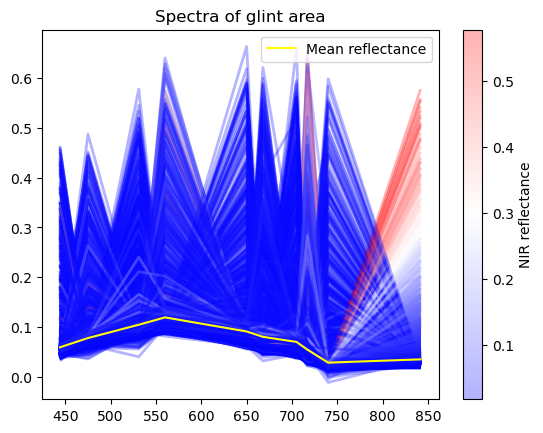

(0.017926583, 0.035379007, 0.5772593)

In [143]:
ES = espect.ExtractSpectral(r"saved_bboxes")
ES.plot_multiline(im_aligned,bboxes_i)

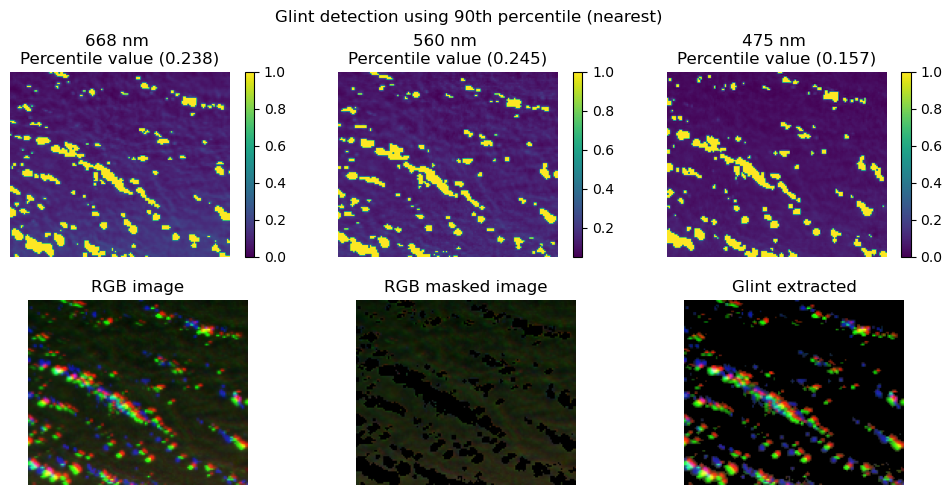

In [221]:
ES = espect.ExtractSpectral(r"saved_bboxes")
bin_mask = ES.identify_glint(im_aligned,bboxes['turbid_glint'],percentile_threshold=90,percentile_method='nearest',mode="rgb")

- glint distribution is spatially similar across the RGB bands but has a bit of offset, possibly due to diffraction of light. But in terms of reflectance magnitude, there is high correlation across the RGB bands at the glint regions (very high reflectance at the glint regions, and low reflectance at non-glint regions)
- NIR band and 668 nm (band 2) are more sensitive to turbid regions compared to 560 nm and 475 nm (bands 1 and 0 respectively), as turbid regions show up as higher reflectance too
- Using NIR band to determine glint threshold is not good at masking glint regions due to the nature of light diffraction (as shown in the `mode='nir'`) because the glint distribution is different at different bands
- using `percentile_threshold` is more robust under different image contrast thanusing absolute reflectance threshold

1. concatenate the identified glint regions indices for those regions selected by `_glint` bboxes
2. get the spectral reflectances for all bands (?) or rgb bands?
3. get the corresponding nearest neighbourhood band reflectances with no glint for each index which will serve as the y-value
4. mask those glint regions using the indices
5. interpolate the masked areas with non-glint regions using the nearest neighbourhood region (inpainting)
6. train a U-net model? with pairs of corrected images and uncorrected images. Or just train a XGBoost model with bands with glint as the features, and non-glint as the `y`

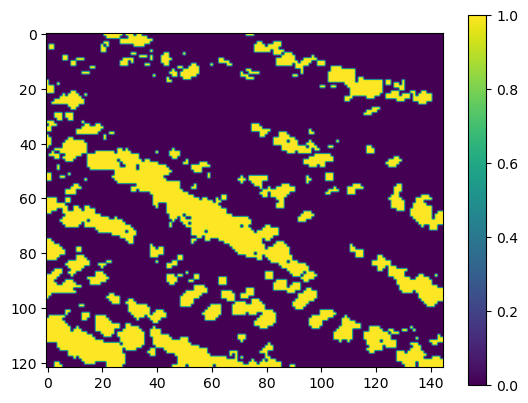

In [216]:
def inpainting(im_aligned,mask):
    """ 
    :param im_aligned (np.ndarray): 10 bands in band order i.e. band 1,2,3,4,5,6,7,8,9,10
    :param mask (np.ndarray): a binary mask, of same size as that of input image, where non-zero pixels corresponds to the area which is to be inpainted
    TODO 
        1. use a horizontal line across the original and corrected image to show the location of where spectrum is drawn
        2. add spectrum of the horizontal line
        3. use cv.INPAINT_NS or CV.INPAINT_TELEA method for inpainting
    """

In [17]:
x = np.ones((3,3,3))
x = np.multiply(x,np.array([1,2,3]))
X = np.take(x,[2,1,0],axis=2)
X[:,:,2]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [4]:
x = np.linspace(1,9,9).reshape(3,3,1)
x = np.repeat(x,3,axis=2)
# X = x[1:3,0:2,:]
X = x.reshape(-1,3)
X[:,0]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [47]:
x = np.ones((3,3,3))
x = np.multiply(x,np.array([1,2,3]))
X = x[:,:,np.array([2,1,0])]
np.mean(X,axis=(0,1))
np.var(X,axis=(0,1))

array([0., 0., 0.])

In [176]:
indices = np.linspace(0,8,9,dtype=int)
indices
idx = np.unravel_index(indices,(3,3))
print(idx)
X = np.linspace(1,25,25).reshape(5,5)
X[idx] = 0
idxes = [idx,idx,idx]
unique_idxes = np.unique(np.vstack([np.column_stack(i) for i in idxes]),axis=0)
unique_idxes[:,0]

(array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64), array([0, 1, 2, 0, 1, 2, 0, 1, 2], dtype=int64))


array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64)

In [144]:
x = np.linspace(0,0.1,9)
print(x)
np.argwhere(x > 0.05)

[0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1   ]


array([[5],
       [6],
       [7],
       [8]], dtype=int64)

In [200]:
x = np.linspace(0,500,100)
np.argwhere(x>np.percentile(x,95))
print(np.percentile(x,95,interpolation='nearest'))
print(np.percentile(x,95))

474.7474747474747
474.99999999999994


In [201]:
np.__version__

'1.21.6'